Below two cells from Kaggle notebook: https://www.kaggle.com/code/scratchpad/notebooka341afdf51/edit

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # for data visualization
import matplotlib.pyplot as plt # to plot charts
from collections import Counter
import os

In [2]:
# Modeling
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve, train_test_split

# Loading the pima indian dataset 


In [3]:
#loading pima dataset
pima_diabetes = pd.read_csv('../data/diabetes.csv')

In [4]:
len(pima_diabetes)

768

# Data exploration and imputation (that is setting zero values to median)

In [5]:
pima_diabetes.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
#before counts
for col in pima_diabetes.columns:
    print(pima_diabetes[col].value_counts())


In [6]:
non_zero_columns = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'Age']

In [7]:
#replace zero values with median of column
for col in non_zero_columns:
    pima_diabetes[col] = pima_diabetes[col].replace(0,pima_diabetes[col].median())

In [10]:
#after counts - no zeroes should be present

#before counts
for col in pima_diabetes.columns:
    print(pima_diabetes[col].value_counts())


1     135
0     111
2     103
3      75
4      68
5      57
6      50
7      45
8      38
9      28
10     24
11     11
13     10
12      9
14      2
15      1
17      1
Name: Pregnancies, dtype: int64
99     17
100    17
117    16
129    14
125    14
       ..
191     1
177     1
44      1
62      1
190     1
Name: Glucose, Length: 135, dtype: int64
72     79
70     57
74     52
78     45
68     45
64     43
80     40
76     39
60     37
62     34
66     30
82     30
88     25
84     23
90     22
58     21
86     21
50     13
56     12
52     11
54     11
75      8
92      8
65      7
94      6
85      6
48      5
96      4
44      4
98      3
100     3
106     3
110     3
55      2
30      2
104     2
46      2
108     2
61      1
38      1
24      1
122     1
102     1
95      1
40      1
114     1
Name: BloodPressure, dtype: int64
23    249
32     31
30     27
27     23
28     20
33     20
18     20
31     19
19     18
39     18
29     17
25     16
37     16
40     16
22     16
26 

In [8]:
#dropping unnamed columns
pima_diabetes.drop(pima_diabetes.columns[pima_diabetes.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)


In [9]:
pima_diabetes.to_csv('../data/diabetes_val_corrected.csv')

# Run these set of cells to generate breakdown of splits across hospitals 

In [13]:
pima_diabetes = pd.read_csv('../data/diabetes_val_corrected.csv', index_col=0)

In [14]:
pima_diabetes.columns


Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [15]:
def get_across_hospital_split(dataset, no_hospital):
    '''
    Split dataset across hospitals evenly and randomly
    '''    
    #dictionary to hold records across each hospital
    hospitals = {}
        
    shuffled = dataset.sample(frac=1)
    result = np.array_split(shuffled, no_hospital) 
    ctr = 1
    
    for part in result:
        hospitals['hospital' + str(ctr)] = part
        ctr += 1
    
    return hospitals

In [16]:
def save_hospital_split_to_file(split_data, hospital_no):
    split_data.to_csv('../data/' + hospital_no + '.csv')

In [17]:
pima_split = get_across_hospital_split(pima_diabetes, 5)

for hospital in pima_split.keys():
    save_hospital_split_to_file(pima_split[hospital], hospital)

All data is always written to the ../data folder and is named either via the hospital_x.csv or if it is the full file - it is named as diabetes.csv

# Train model with different classifiers and report accuracy 

Data Pre-processing

In [18]:
from sklearn.preprocessing import QuantileTransformer

In [19]:
q  = QuantileTransformer()
X = q.fit_transform(pima_diabetes)
transformedDF = q.transform(X)
transformedDF = pd.DataFrame(X)
transformedDF.columns = pima_diabetes.columns

/Users/shruthichari/miniconda3/lib/python3.9/site-packages/sklearn/preprocessing/_data.py:2583: UserWarning: n_quantiles (1000) is greater than the total number of samples (768). n_quantiles is set to n_samples.
  warnings.warn(
/Users/shruthichari/miniconda3/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(


In [20]:
pima_diabetes

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,30.5,33.6,0.627,50,1
1,1,85,66,29,30.5,26.6,0.351,31,0
2,8,183,64,23,30.5,23.3,0.672,32,1
3,1,89,66,23,94.0,28.1,0.167,21,0
4,0,137,40,35,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180.0,32.9,0.171,63,0
764,2,122,70,27,30.5,36.8,0.340,27,0
765,5,121,72,23,112.0,26.2,0.245,30,0
766,1,126,60,23,30.5,30.1,0.349,47,1


In [21]:
transformedDF

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,0.747718,0.810300,0.494133,0.801825,0.256193,0.591265,0.750978,0.889831,1.0
1,0.232725,0.091265,0.290091,0.644720,0.256193,0.213168,0.475880,0.558670,0.0
2,0.863755,0.956975,0.233377,0.357888,0.256193,0.077575,0.782269,0.585398,1.0
3,0.232725,0.124511,0.290091,0.357888,0.662973,0.284224,0.106258,0.000000,0.0
4,0.000000,0.721643,0.005215,0.801825,0.834420,0.926988,0.997392,0.606258,1.0
...,...,...,...,...,...,...,...,...,...
763,0.940678,0.278357,0.649935,0.978488,0.853977,0.552803,0.110821,0.976532,0.0
764,0.387223,0.561930,0.405476,0.591917,0.256193,0.760756,0.456323,0.411995,0.0
765,0.677966,0.549544,0.494133,0.357888,0.711864,0.198827,0.254889,0.529335,0.0
766,0.232725,0.619948,0.135593,0.357888,0.256193,0.385919,0.473924,0.867014,1.0


## creating a train and test dataset with the transformed data 

In [ ]:
from sklearn.metrics import classification_report

In [41]:
## Separate train dataset and test dataset
def generate_train_test_split(transformedDF, test_size):
    features = transformedDF.drop(["Outcome"], axis=1)
    labels = transformedDF["Outcome"]
    x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.30, random_state=7)
    return x_train, x_test, y_train, y_test

In [42]:
def evaluate_model(models, x_train, y_train):
    """
    Takes a list of models and returns chart of cross validation scores using mean accuracy
    """
    
    # Cross validate model with Kfold stratified cross val
    kfold = StratifiedKFold(n_splits = 10)
    
    result = []
    for model in models :
        model_cv = cross_val_score(estimator = model[1], X = x_train, y = y_train, scoring = "accuracy", 
                                      cv = kfold, n_jobs=4)
        result.append(model_cv)

    cv_means = []
    cv_std = []
    for cv_result in result:
        #print(cv_result)
        cv_means.append(cv_result.mean())
        cv_std.append(cv_result.std())

    result_df = pd.DataFrame({
        "CrossValMeans":cv_means,
        "CrossValerrors": cv_std,
        "Models":[m[0] for m in models]
    })

    # Generate chart
    bar = sns.barplot(x = "CrossValMeans", y = "Models", data = result_df, orient = "h")
    bar.set_xlabel("Mean Accuracy")
    bar.set_title("Cross validation scores")
    return result_df

In [43]:
def fit_and_predict_models(model, x_train, y_train, x_test, y_test):
    '''
    Function to train a model, test it and report F1, precision and recall on the test predictions
    '''
    model[1].fit(x_train, y_train)
    y_pred_model = model[1].predict(x_test)
    print('Model : ' + model[0])
    print(classification_report(y_test, y_pred_model))

# Training and test on models - i.e., calling all before defined functions

Model : Logistic Regression
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       147
         1.0       0.66      0.61      0.63        84

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231

Model : Decision Tree
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       147
         1.0       0.58      0.58      0.58        84

    accuracy                           0.69       231
   macro avg       0.67      0.67      0.67       231
weighted avg       0.69      0.69      0.69       231

Model : Random Forest
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       147
         1.0       0.72      0.68      0.70        84

    accuracy                           0.79       231
   macro avg       0.77      0.76      0.77       231
we

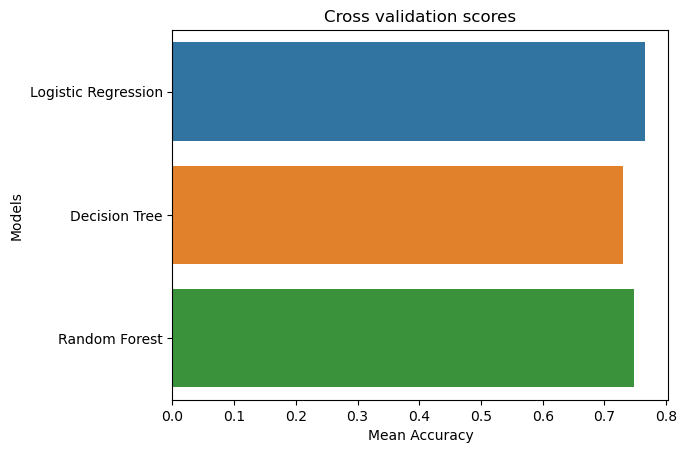

In [44]:
random_state = 30
models = [
    ['Logistic Regression', LogisticRegression(random_state = random_state, solver='liblinear')],
    ['Decision Tree',DecisionTreeClassifier(random_state = random_state)],
    ['Random Forest', RandomForestClassifier(random_state = random_state)],
]

x_train, x_test, y_train, y_test = generate_train_test_split(transformedDF, 0.30)
evaluate_model(models, x_train, y_train)

for model in models:
    fit_and_predict_models(model, x_train, y_train, x_test, y_test)


Model : Logistic Regression
              precision    recall  f1-score   support

         0.0       0.79      0.82      0.80       147
         1.0       0.66      0.61      0.63        84

    accuracy                           0.74       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.74      0.74      0.74       231

Model : Decision Tree
              precision    recall  f1-score   support

         0.0       0.76      0.76      0.76       147
         1.0       0.58      0.58      0.58        84

    accuracy                           0.69       231
   macro avg       0.67      0.67      0.67       231
weighted avg       0.69      0.69      0.69       231

Model : Random Forest
              precision    recall  f1-score   support

         0.0       0.82      0.85      0.84       147
         1.0       0.72      0.68      0.70        84

    accuracy                           0.79       231
   macro avg       0.77      0.76      0.77       231
we